# VVIX ZScore Model

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\VIXCurveStrategies\root\src")
from VVIXZscoreStrats import VVIXZscoreStrats
from BackgroundFunction import BackgroundFunctions

In [3]:
def get_rtn() -> pd.DataFrame: 
    
    df_out = (VVIXZscoreStrats().get_zscore().assign(
        group_var = lambda x: "Short: " +  x.short_leg + " ZScore Window: " + x.window.astype(str) + "d").
        drop(columns = ["lag_zscore"]).
        rename(columns = {"window": "param"}))
    
    return df_out

df = get_rtn()

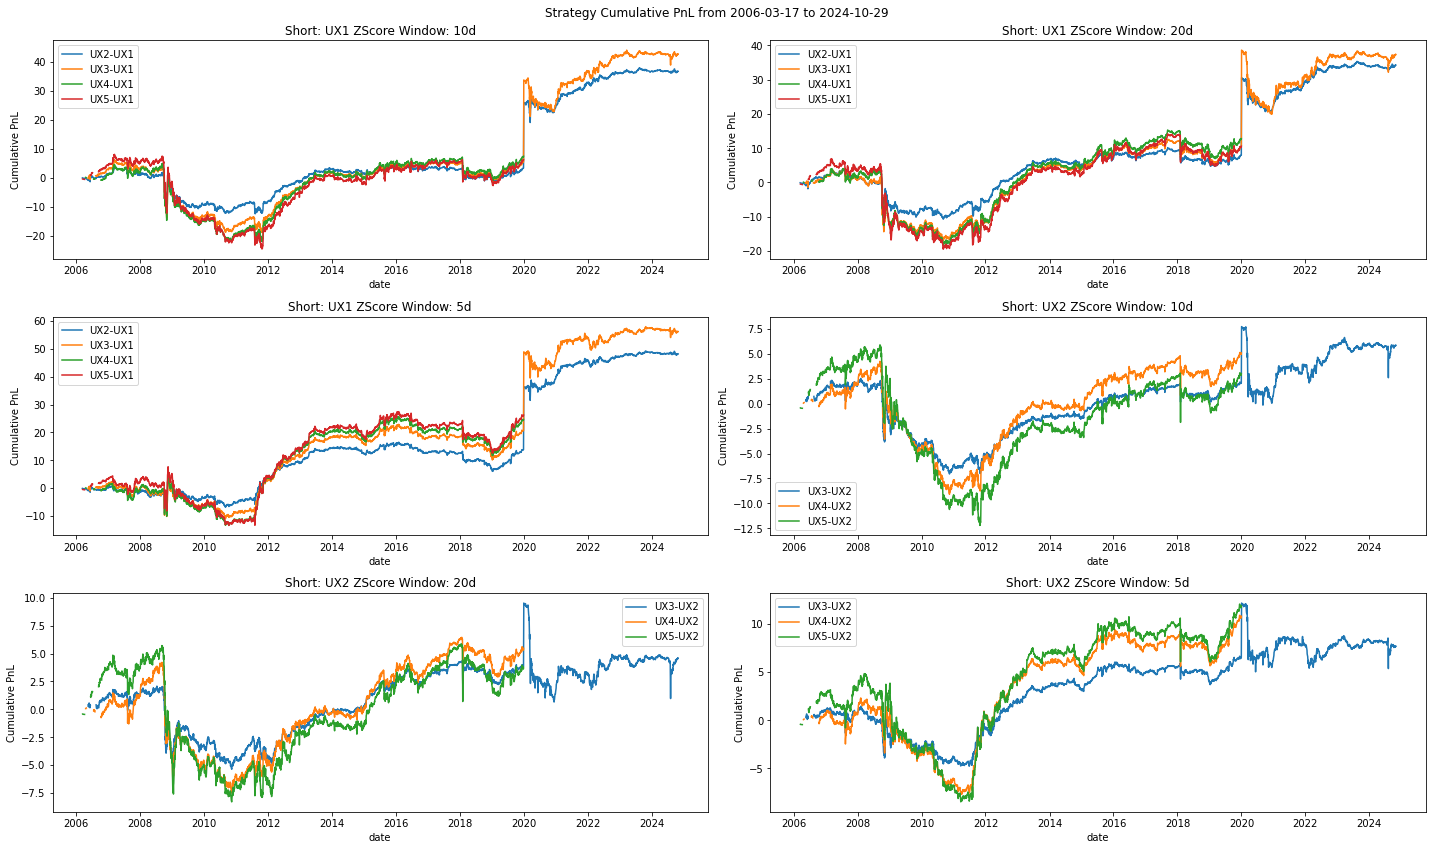

In [4]:
BackgroundFunctions().plot_backtest_rtn(df)

In [5]:
def get_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_grouper = df[["strat", "short_leg"]].drop_duplicates()

    df_out = (df[
        ["date", "param", "strat", "spread", "signal_spread"]].
        melt(id_vars = ["date", "param", "strat"]).
        drop(columns = ["date"]).
        groupby(["param", "strat", "variable"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        drop(columns = ["mean_rtn", "std_rtn"]).
        pivot(index = ["param", "strat"], columns = "variable", values = "sharpe").
        reset_index().
        assign(param = lambda x: x.param.astype(str) + "d").
        pivot(index = ["strat", "spread"], columns = "param", values = "signal_spread").
        reset_index().
        merge(right = df_grouper, how = "inner", on = ["strat"]).
        rename(columns = {"spread": "None"}))
    
    return df_out

df_sharpe = get_sharpe(df)

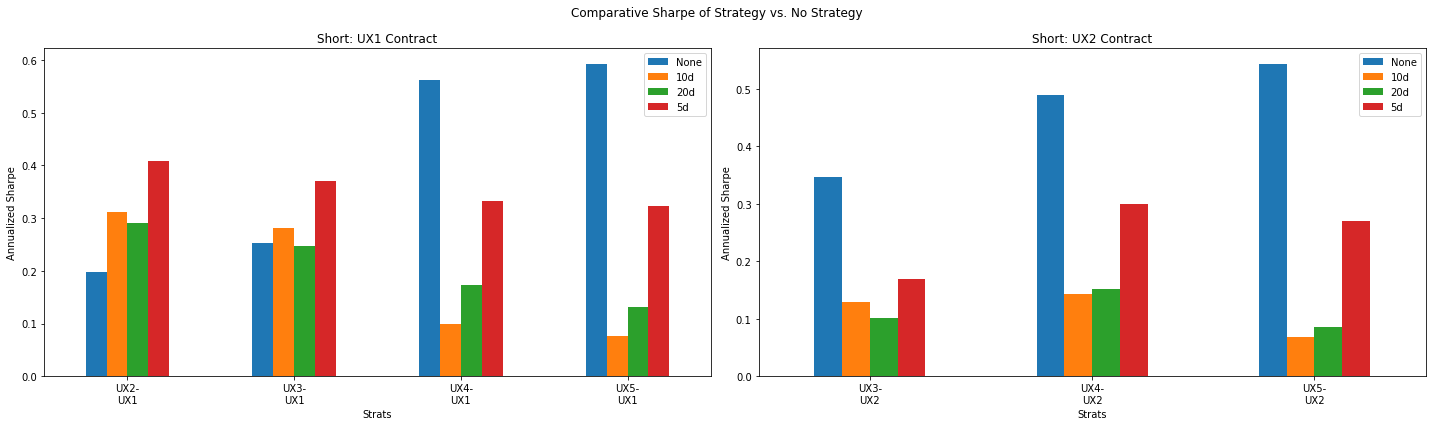

In [6]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_sharpe.short_leg.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_sharpe.query(
            "short_leg == @group_var").
            drop(columns = ["short_leg"]).
            assign(strat = lambda x: x.strat.str.replace("-", "-\n")).
            set_index("strat").
            plot(
                ax   = ax,
                kind = "bar",
                ylabel = "Annualized Sharpe",
                xlabel = "Strats",
                title  = "Short: {} Contract".format(group_var)))

        ax.tick_params(axis = "x", rotation = 0)

    fig.suptitle("Comparative Sharpe of Strategy vs. No Strategy")
    plt.tight_layout()
    
plot_sharpe(df_sharpe)

# Combining Everything

In this case going to build a strategy via this method <br>
1. Rolling Sharpe Maximization per each spread to optimize the z-score window
2. Equal Volatility Contribution 

In [7]:
def _get_roll_sharpe(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_mean   = lambda x: x.signal_spread.ewm(span = window, adjust = False).mean(),
            roll_std    = lambda x: x.signal_spread.ewm(span = window, adjust = False).std(),
            roll_sharpe = lambda x: x.roll_mean / x.roll_std,
            lag_sharpe  = lambda x: x.roll_sharpe.shift()).
        dropna())
    
    return df_out

def _get_max_sharpe(df: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df.query(
        "lag_sharpe == lag_sharpe.max()").
        head(1))
    
    return df_out

In [8]:
def get_roll_sharpe_max(df: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_roll_sharpe = (df.assign(
        strat_name = lambda x: x.strat + " " + x.param.astype(str)).
        groupby("strat_name").
        apply(_get_roll_sharpe, window).
        reset_index(drop = True))

    df_max_sharpe = (df_roll_sharpe.groupby(
        ["date", "strat"]).
        apply(_get_max_sharpe).
        reset_index(drop = True))
    
    return df_max_sharpe

df_max_sharpe = get_roll_sharpe_max(df)

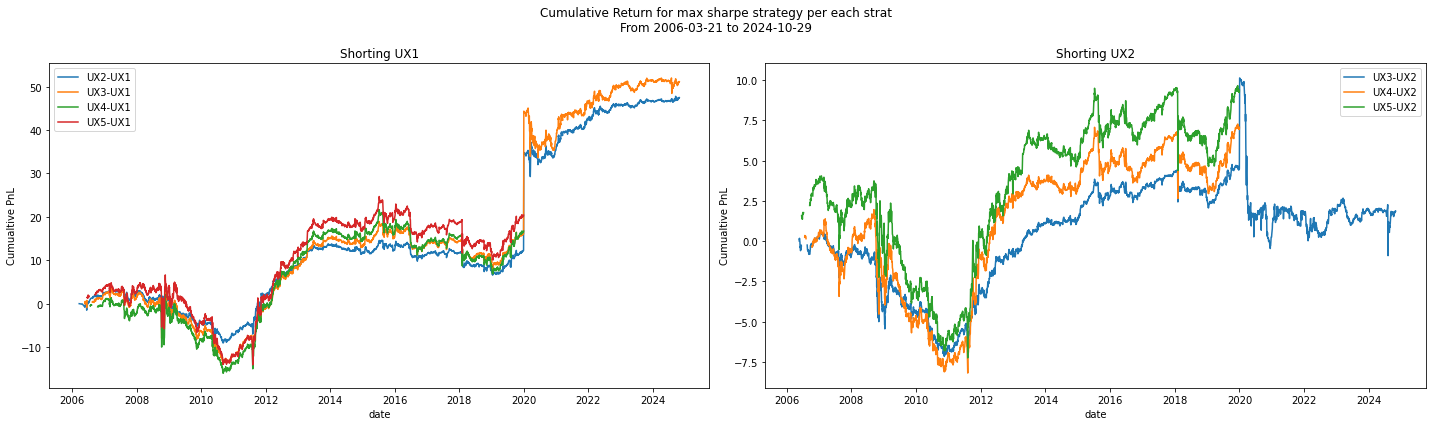

In [9]:
def plot_max_sharpe_strat(df_max_sharpe: pd.DataFrame) -> plt.Figure:
    
    short_legs = df_max_sharpe.short_leg.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(short_legs), figsize = (20,6))

    for short_leg, ax in zip(short_legs, axes.flatten()):

        (df_max_sharpe.query(
            "short_leg == @short_leg")[
            ["date", "strat", "signal_spread"]].
            rename(columns = {"strat": ""}).
            pivot(index = "date", columns = "", values = "signal_spread").
            cumsum().
            plot(
                ax     = ax,
                title  = "Shorting {}".format(short_leg),
                ylabel = "Cumualtive PnL"))
        
    fig.suptitle("Cumulative Return for max sharpe strategy per each strat\nFrom {} to {}".format(
        df_max_sharpe.date.min(),
        df_max_sharpe.date.max()))
    
    plt.tight_layout()
    
plot_max_sharpe_strat(df_max_sharpe)

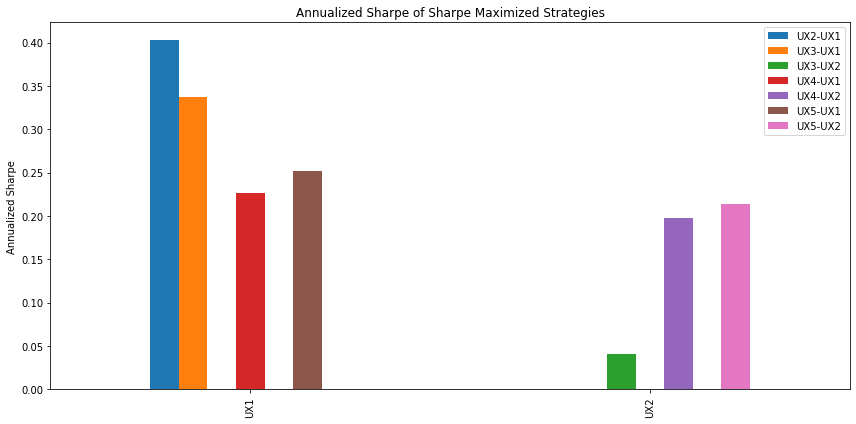

In [10]:
def plot_max_sharpe(df_max_sharpe: pd.DataFrame) -> plt.Figure: 
    
    df_sharpe = (df_max_sharpe[
        ["strat", "signal_spread"]].
        groupby("strat").
        agg(["mean", "std"])
        ["signal_spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        merge(
            right = df_max_sharpe[["strat", "short_leg"]].drop_duplicates(), 
            how   = "inner", 
            on    = ["strat"]))

    (df_sharpe[
        ["short_leg", "strat", "sharpe"]].
        rename(columns = {"strat": ""}).
        pivot(index = "short_leg", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe of Sharpe Maximized Strategies",
            figsize = (12,6)))

    plt.tight_layout()
    
plot_max_sharpe(df_max_sharpe)

In [11]:
def _get_erc(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_std = (df[
        ["date", "signal_spread", "strat"]].
        pivot(index = "date", columns = "strat", values = "signal_spread").
        ewm(span = window, adjust = False).
        std().
        shift().
        reset_index().
        melt(id_vars = "date").
        dropna().
        assign(value = lambda x: 1 / x.value))
    
    df_cum = (df_std.drop(
        columns = ["strat"]).
        groupby("date").
        agg("sum").
        reset_index().
        query("value != inf").
        dropna().
        rename(columns = {"value": "cum_val"}))
    
    df_weight = (df_std.merge(
        right = df_cum, how = "inner", on = ["date"]))
    
    df_out = (df.merge(
        right = df_weight, how = "inner", on = ["date", "strat"]).
        assign(weight_signal_spread = lambda x: x.value / x.cum_val * x.signal_spread))
    
    return df_out

def get_erc(df_max_shapre: pd.DataFrame, window: int = 30) -> pd.DataFrame:

    df_out = (df_max_sharpe.groupby(
        "short_leg").
        apply(_get_erc, window).
        reset_index(drop = True))
    
    return df_out

df_erc = get_erc(df_max_sharpe)

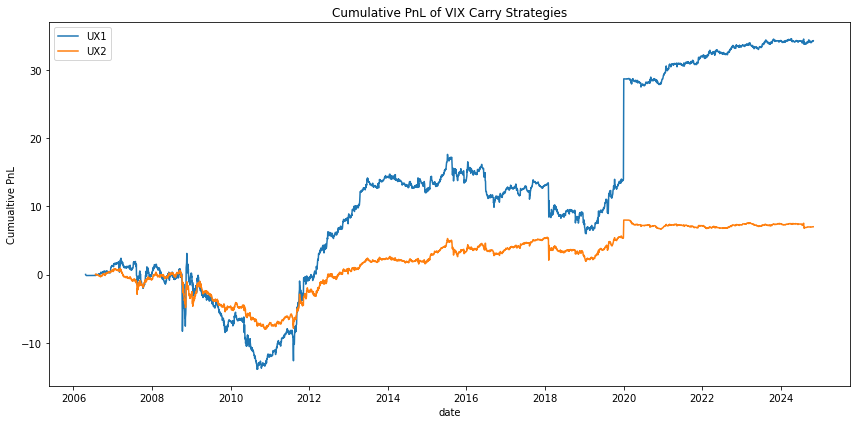

In [12]:
def plot_erc_return(df_erc: pd.DataFrame) -> pd.DataFrame: 
    
    (df_erc[
        ["date", "short_leg", "weight_signal_spread"]].
        groupby(["date", "short_leg"]).
        agg("sum").
        reset_index().
        rename(columns = {"short_leg": ""}).
        pivot(index = "date", columns = "", values = "weight_signal_spread").
        cumsum().
        plot(
            figsize = (12,6),
            ylabel  = "Cumualtive PnL",
            title   = "Cumulative PnL of VIX Carry Strategies"))
    
    plt.tight_layout()
    
plot_erc_return(df_erc)